| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [42]:
library("dplyr", warn.conflicts = FALSE)
library("ggplot2")
library("geosphere")
library("spatstat", warn.conflicts = FALSE)

# Exercise 1: Bayesian Inference for Poisson model

The number of particles emitted by a radioactive source during a fixed interval of time ($\Delta t = 10 s$) follows a Poisson distribution on the parameter $\mu$. The number of particles observed during consecutive time intervals is: 4, 1, 3, 1, 5 and 3.

(a) Assuming a positive uniform prior distribution for the parameter $\mu$:
- determine and draw the posterior distribution for $\mu$, given the data;
- evaluate mean, median and variance, both analytically and numerically in R.

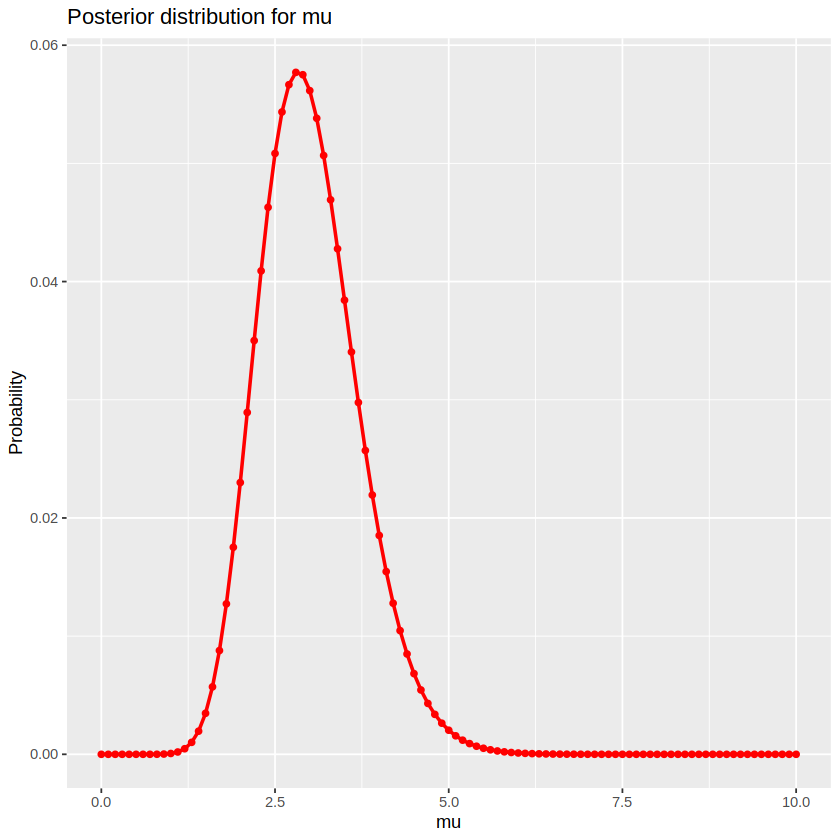

In [43]:
delta_t <- 10
num_occ <- c(4, 1, 3, 1, 5, 3)

post_un <- function(x, mu, limits) {
  uniform <- 1 / (limits[2] - limits[1])
  n <- length(x)
  exp <- sum(x)

  normalization <- sum(uniform * exp(-mu * n) * (mu * n) **(exp))

  return(uniform * exp(- mu * n) * (mu * n)**(exp) / normalization)
}

mu <- seq(0, 10, 0.1)
post_values <- post_un(num_occ, mu, c(min(mu), max(mu)))

ggplot(data = data.frame(mu, post_values), aes(x = mu, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability")

In [54]:
mean_analytical <- sum(mu * post_values)
variance_analytical <- sum((mu**2) * post_values) - mean_analytical**2


mean_numerical <- weighted.mean(mu, post_values)
median_numerical <- weighted.median(mu, post_values)
variance_numerical <- weighted.var(mu, post_values)

cat("Analytical Mean:", mean_analytical, "\n")
#cat("Analytical Median:", median_analytical, "\n")
cat("Analytical Variance:", variance_analytical, "\n \n")

cat("Numerical Mean:", mean_numerical, "\n")
cat("Numerical Median:", median_numerical, "\n")
cat("Numerical Variance:", variance_numerical, "\n")


Analytical Mean: 3 
Analytical Variance: 0.5 
 
Numerical Mean: 3 
Numerical Median: 2.85 
Numerical Variance: 0.5212406 


(b) assuming a Gamma prior such that the expected value is $\mu = 3$ with a standard deviation $\sigma = 1$:
- determine and draw the posterior distribution for $\mu$, given the data:
- evaluate mean, median and variance, both analytically and numerically in R.

(c) evaluate a 95% credibility interval for the results obtained with different priors. Compare the result with that obtained using a normal approximation for the posterior distribution, with the same mean and standard deviation.